In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (20.0, 10.0)

### data set reading

In [2]:
df = pd.read_csv('NIFTY_50.csv') ##Source File to be changed here
df.head()

,Date,Close/Last,Volume,Open,High,Low
0,03/1/2000,1592.2,25358322,1482.15,1592.90,1482.15
1,04/1/2000,1638.7,38787872,1594.40,1641.95,1594.40
2,05/1/2000,1595.8,62153431,1634.55,1635.50,1555.05
3,06/1/2000,1617.6,51272875,1595.80,1639.00,1595.80
4,07/1/2000,1613.3,54315945,1616.60,1628.25,1597.20


### preprocessing data set to perform analysis

In [3]:
df.shape

(5353, 6)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5353 entries, 0 to 5352
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        5353 non-null   object 
 1   Close/Last  5353 non-null   float64
 2   Volume      5353 non-null   int64  
 3   Open        5353 non-null   float64
 4   High        5353 non-null   float64
 5   Low         5353 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 251.0+ KB


In [5]:
df1 = df.iloc[:,1]
df1.head()

0    1592.2
1    1638.7
2    1595.8
3    1617.6
4    1613.3
Name: Close/Last, dtype: float64

In [6]:
df1.tail()

5348    15680.00
5349    15722.20
5350    15834.35
5351    15818.25
5352    15879.65
Name: Close/Last, dtype: float64

In [7]:
df1 = df1.replace('[\$,]', '', regex=True).astype(float)
df1.head()

0    1592.2
1    1638.7
2    1595.8
3    1617.6
4    1613.3
Name: Close/Last, dtype: float64

Text(0, 0.5, 'stock price')

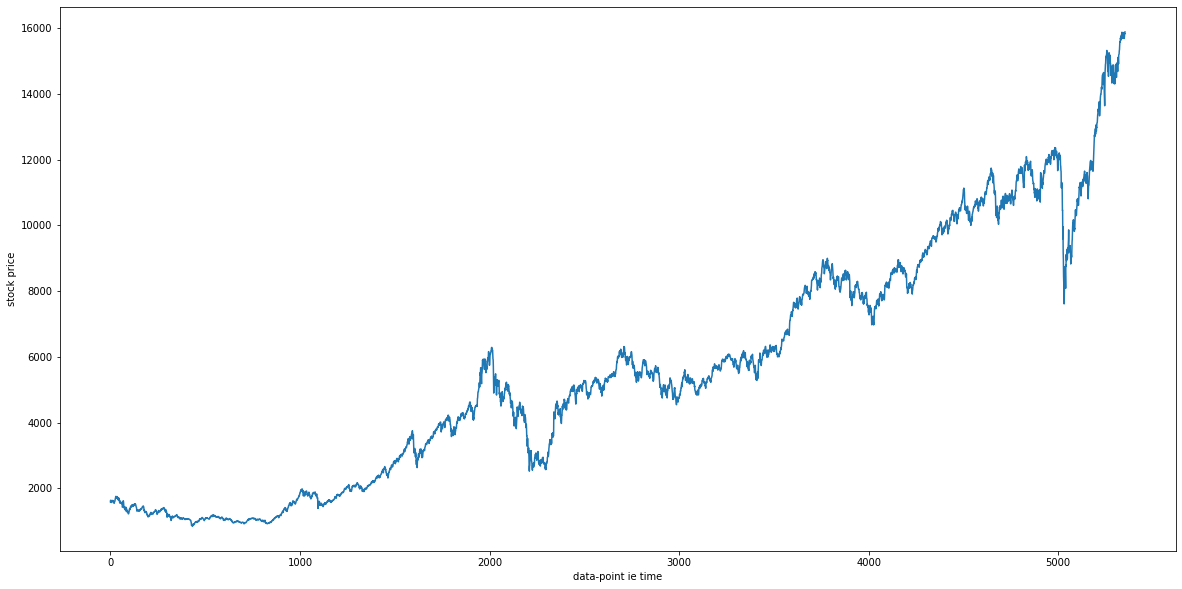

In [8]:
plt.plot(df1)
plt.xlabel("data-point ie time")
plt.ylabel("stock price")

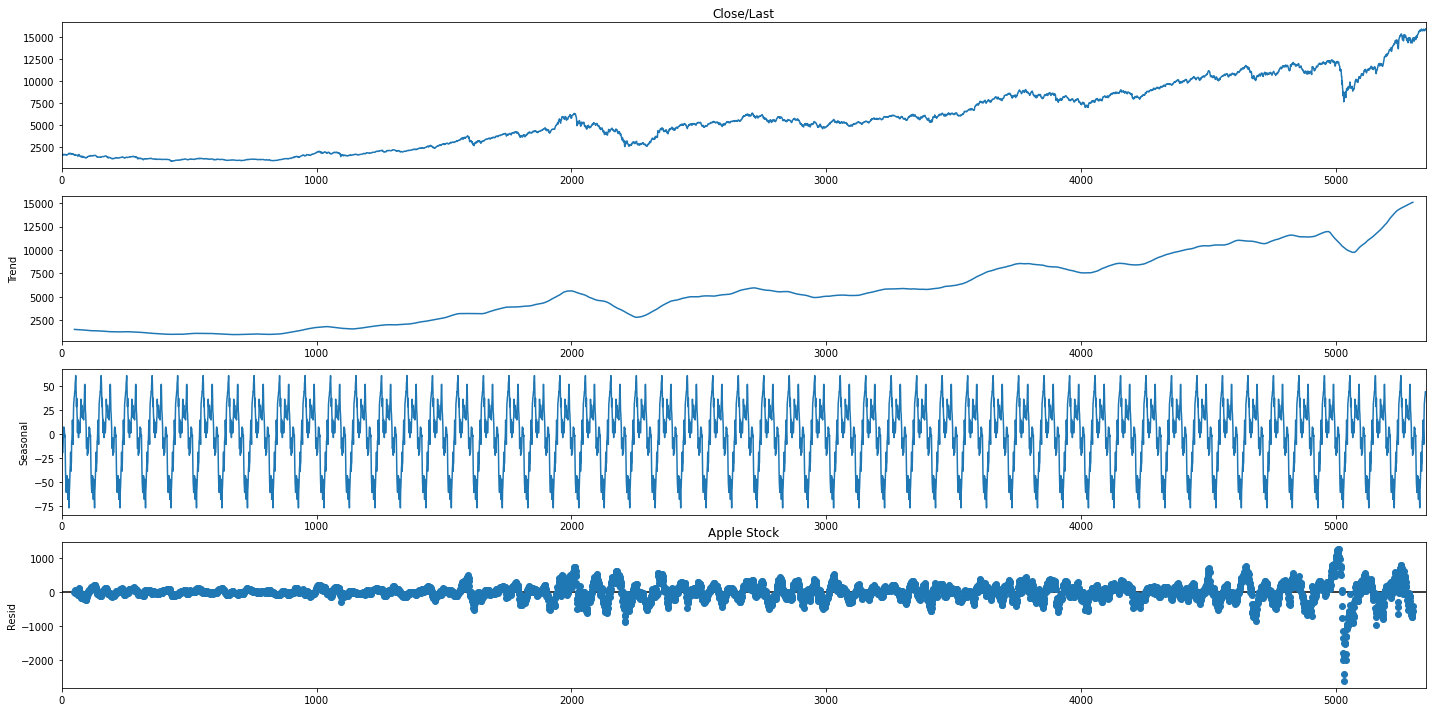

In [9]:
#show the components of this time series
from statsmodels.tsa.seasonal import seasonal_decompose

result  = seasonal_decompose(pd.Series(df1),period=100)

result.plot()
plt.title('Apple Stock')
plt.show()

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))

In [11]:
df1.shape

(5353,)

In [12]:
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [13]:
print(df1)
print('\n df1 present shape : ', df1.shape)

[[0.04911667]
 [0.05221141]
 [0.04935626]
 ...
 [0.99698512]
 [0.9959136 ]
 [1.        ]]

 df1 present shape :  (5353, 1)


### splitting data (70/30)

In [14]:
training_size = int(len(df1)*0.7)
test_size = len(df1) - training_size
print('Training Size : ',training_size)
print('Test Size : ',test_size)

Training Size :  3747
Test Size :  1606


In [15]:
train_data, test_data = df1[0:training_size,:],df1[training_size:len(df1),:]
print('Training Data Shape : ', train_data.shape)
print('Test Data Shape: ', test_data.shape)

Training Data Shape :  (3747, 1)
Test Data Shape:  (1606, 1)


### | windowing data set |

In [16]:
def create_dataset(dataset, window=1):
    dataX, dataY= [], []
    for i in range(len(dataset)-window-1):
        a = dataset[i:(i+window),0]
        dataX.append(a)
        dataY.append(dataset[i+window,0])
    return np.array(dataX), np.array(dataY)

In [17]:
window = 100
X_train, y_train = create_dataset(train_data, window=100)
X_test, y_test = create_dataset(test_data, window=100)

In [18]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3646, 100) (3646,)
(1505, 100) (1505,)


In [19]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

### lstm coding

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [21]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (100,1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer = 'adam')

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


### fitting data to model

In [23]:
model.fit(X_train,y_train,validation_data = (X_test,y_test), epochs = 2, batch_size=64,verbose=1)

Epoch 1/2
57/57 [==============================] - 14s 160ms/step - loss: 0.0022 - val_loss: 0.0043
Epoch 2/2
57/57 [==============================] - 8s 132ms/step - loss: 1.5490e-04 - val_loss: 0.0025


In [24]:
y_pred = scaler.inverse_transform(model.predict(X_test))

48/48 [==============================] - 2s 26ms/step


In [25]:
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [26]:
y_pred[:5]

array([[8236.362],
       [8226.079],
       [8214.046],
       [8199.901],
       [8184.022]], dtype=float32)

In [27]:
y_test[:5]

array([[8022.4 ],
       [8124.45],
       [7965.35],
       [7982.9 ],
       [8013.9 ]])

### evaluation

In [28]:
import math
from sklearn.metrics import mean_squared_error

rmse_score = math.sqrt(mean_squared_error(y_test,y_pred))
print('Root Mean Squared Error(test) : ',rmse_score)

Root Mean Squared Error(test) :  745.0616480398627


In [29]:
from sklearn.metrics import r2_score
print('R-squared Score  : ',r2_score(y_test,y_pred))

R-squared Score  :  0.8618414240284448


### visualization + plotting

114/114 [==============================] - 3s 27ms/step


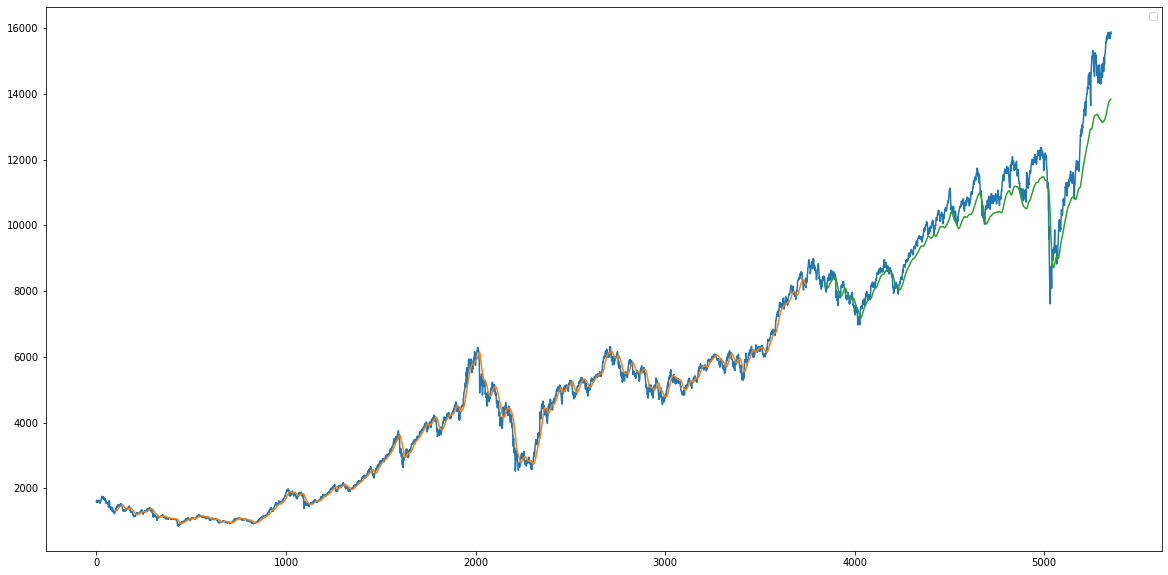

In [30]:
# shift train predictions for plotting
train_predict = scaler.inverse_transform(model.predict(X_train))

look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = y_pred
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend()
plt.show()

### predicting 30 Days future value

In [31]:
x_input=test_data[len(test_data)-100:].reshape(1,-1)
x_input.shape

(1, 100)

In [32]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [33]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        #print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        #print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

#print(lst_output)

In [34]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [35]:
print(scaler.inverse_transform(lst_output))

[[13841.1014293 ]
 [13833.27310674]
 [13810.26727791]
 [13771.99796648]
 [13720.08887099]
 [13656.94732823]
 [13585.15441883]
 [13507.1631545 ]
 [13425.09070199]
 [13340.69061987]
 [13255.3179307 ]
 [13170.00524584]
 [13085.47709484]
 [13002.24127532]
 [12920.61482494]
 [12840.7849213 ]
 [12762.85007893]
 [12686.82731396]
 [12612.70856613]
 [12540.4490561 ]
 [12469.98788399]
 [12401.26773224]
 [12334.21784952]
 [12268.77017125]
 [12204.8655887 ]
 [12142.44409758]
 [12081.44211124]
 [12021.80947683]
 [11963.50410177]
 [11906.46866852]]


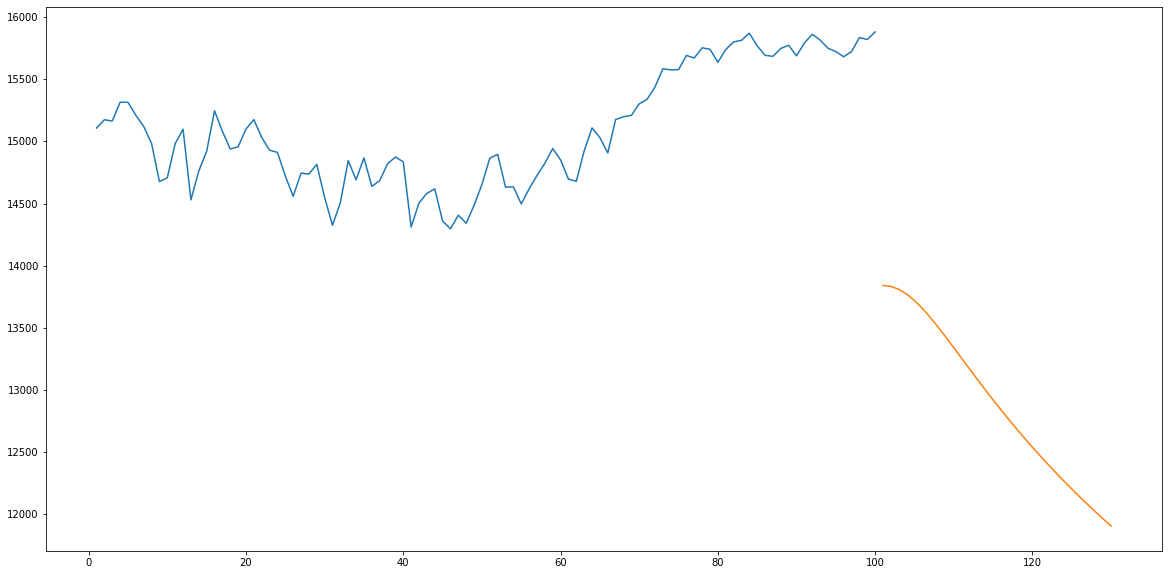

In [36]:
plt.plot(day_new,scaler.inverse_transform(df1[len(df1)-100:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

Dataset File 

https://www.kaggle.com/datasets/tarunpaparaju/apple-aapl-historical-stock-data